In [176]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import display
from PIL import Image, ImageOps
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import make_grid

Initially all images were in the training folder. Randomly select 20% and move them to the validation folder.

In [20]:
for dog in ["duncan", "toast"]:
    source = f"dataset/train/{dog}"
    destination = f"dataset/val/{dog}"
    files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f)) if f.lower().endswith(".jpg")]
    num_to_move = int(len(files) * 0.2)
    files_to_move = random.sample(files, num_to_move)

    for file in files_to_move:
        shutil.move(os.path.join(source, file), os.path.join(destination, file))

Visualize an example image.

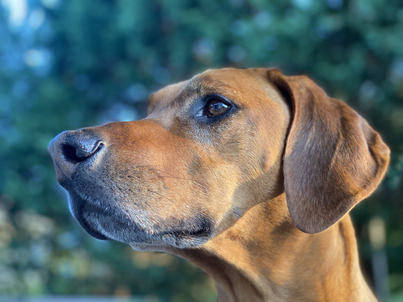

In [36]:
scale = 0.1
with Image.open("dataset/train/toast/IMG_0559.jpg") as image:
    display(image.resize((int(image.width * scale), int(image.height * scale)), Image.LANCZOS))

Calculate summary statistics on image sizes.

In [44]:
images = []
for folder, subfolders, filenames in os.walk("dataset"):
    for image in filenames:
        if image.lower().endswith(".jpg"):
            images.append(folder + "/" + image)

sizes = []
rejected = []
for item in images:
    try:
        with Image.open(item) as img:
            sizes.append(img.size)
    except:
        rejected.append(item)

print(len(rejected))

0


In [49]:
df = pd.DataFrame(sizes, columns=["width", "height"])

In [47]:
df["width"].describe()

count     200.000000
mean     3943.400000
std       408.450781
min      1884.000000
25%      4032.000000
50%      4032.000000
75%      4032.000000
max      6000.000000
Name: width, dtype: float64

In [48]:
df["height"].describe()

count     200.00000
mean     3108.49000
std       321.83202
min      1637.00000
25%      3024.00000
50%      3024.00000
75%      3024.00000
max      4032.00000
Name: height, dtype: float64

Create transforms, datasets, and dataloaders.

In [145]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # Choosing not to rotate because dataset already has a good distribution of realistic angles
    # transforms.RandomRotation(10),
    transforms.Lambda(ImageOps.exif_transpose),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = train_transform

In [146]:
train_data = datasets.ImageFolder("dataset/train", transform=train_transform)
val_data = datasets.ImageFolder("dataset/val", transform=val_transform)

class_names = train_data.classes
print(class_names)

['duncan', 'toast']


In [147]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [273]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [274]:
for images, labels in train_loader:
    break

In [275]:
images.shape

torch.Size([10, 3, 224, 224])

In [276]:
labels

tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

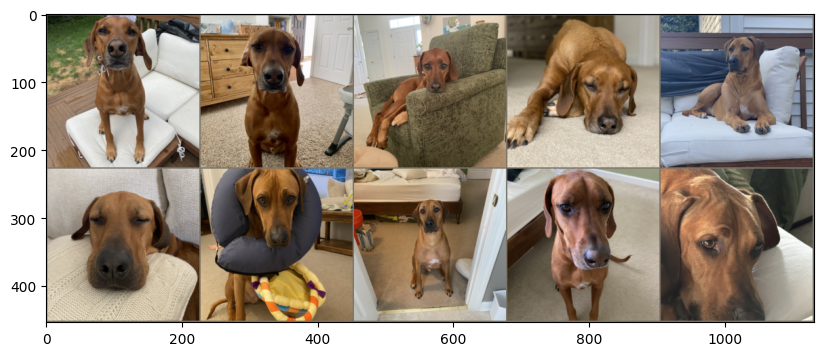

In [277]:
image_grid = make_grid(images, nrow=5)
inverse_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean, std)],
    std=[1/s for s in std]
)
inverse_grid = inverse_normalize(image_grid)
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(inverse_grid.numpy(), (1,2,0)))

Load pretrained model and do transfer learning.

In [281]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer, which unfreezes it
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
start_time = time.time()
num_epochs = 10
train_losses = []
train_correct_list = []
val_losses = []
val_correct_list = []

for epoch in range(num_epochs):
    train_correct = 0
    val_correct = 0

    for X_train, y_train in train_loader:
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # For calculating running accuracy
        predicted = torch.argmax(y_pred, dim=1)
        train_correct += (predicted == y_train).sum()

    train_losses.append(loss)
    train_correct_list.append(train_correct)
    accuracy = train_correct.item() * 100 / (batch_size * len(train_loader))
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    with torch.no_grad():
        for X_val, y_val in val_loader:
            y_pred = model(X_val)
            predicted = torch.argmax(y_pred, dim=1)
            val_correct += (predicted == y_val).sum()
            
        loss = criterion(y_pred, y_val)
        val_losses.append(loss)
        val_correct_list.append(val_correct)

total_time = time.time() - start_time
print(total_time)

Epoch 1, Loss: 0.4433, Accuracy: 53.75%
Epoch 2, Loss: 0.5934, Accuracy: 73.75%
Epoch 3, Loss: 0.4799, Accuracy: 80.00%
Epoch 4, Loss: 0.4926, Accuracy: 86.88%
Epoch 5, Loss: 0.3414, Accuracy: 84.38%
Epoch 6, Loss: 0.5427, Accuracy: 81.88%
Epoch 7, Loss: 0.3883, Accuracy: 86.88%
Epoch 8, Loss: 0.2473, Accuracy: 91.25%
Epoch 9, Loss: 0.2282, Accuracy: 93.75%
Epoch 10, Loss: 0.4194, Accuracy: 90.00%
207.65410923957825


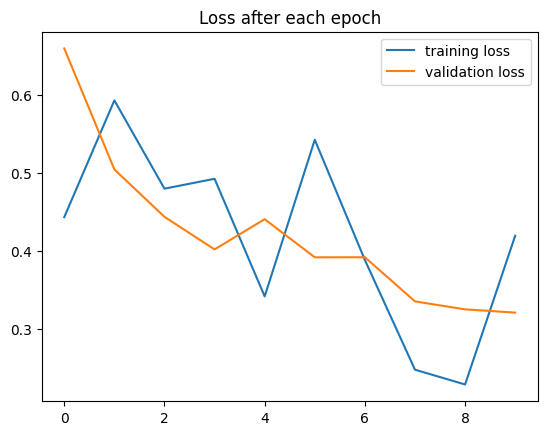

In [282]:
plt.plot([loss.item() for loss in train_losses], label="training loss")
plt.plot([loss.item() for loss in val_losses], label="validation loss")
plt.title("Loss after each epoch")
plt.legend();

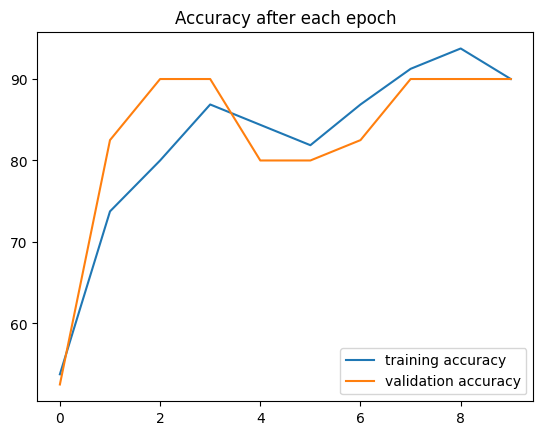

In [283]:
plt.plot([n.item() * 100 / (batch_size * len(train_loader)) for n in train_correct_list], label="training accuracy")
plt.plot([n.item() * 100 / len(val_data) for n in val_correct_list], label="validation accuracy")
plt.title("Accuracy after each epoch")
plt.legend();

duncan


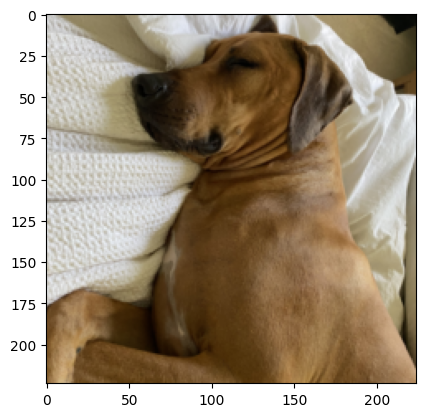

In [284]:
image_index = 0
model.eval()

with torch.no_grad():
    pred = model(val_data[image_index][0].view(1,3,224,224)).argmax()

image = inverse_normalize(val_data[image_index][0])
plt.imshow(np.transpose(image.numpy(), (1,2,0)))
print(class_names[pred.item()])